# <u>Chapter 9</u>: Text Clustering

Algorithms that learn the structure of the data without any assistance (no labels or classes given) are part of unsupervised learning. This notebook examines problems from this perspective, intending to automatically cluster text data into different categories. Specifically, text clustering is the process of dividing a population of samples into various groups, such that the data points in the same category are more similar than those in other ones—the aim is to locate functional patterns within each group and decipher why this happens.

Notice that you need an Internet connection to run this notebook.

In [38]:
!pip install simpleaudio
!pip install googlesearch-python
!pip install SpeechRecognition
!pip install pydub
!pip install jiwer
!pip install requests
!pip install fuzzysearch
!pip install flashtext
!pip install kneed

You should consider upgrading via the 'C:\Users\tsouraki\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\tsouraki\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\tsouraki\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\tsouraki\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\tsouraki\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\tsouraki\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\tsouraki\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\tsouraki\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\tsouraki\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## Preprocessing the data

The first task is to read the file with the meta-information about the corpus.

In [39]:
import pandas as pd

# Read the data from the reduced csv file.
data = pd.read_csv('./data/metadata.csv', usecols=range(2), names=['audiofile', 'transcription'], sep="|")
data.head()

,audiofile,transcription
0,LJ001-0001,"Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...


The dataset lacks any information about the text source of each audio transcription. We extract this information by first downloading the content of the seven books.

In [40]:
import os
import requests
from fuzzysearch import find_near_matches

# Check whether the file with the book's ids exists.
file_exists = os.path.exists("./data/book_id.csv")

if not file_exists:

    # Download the content of each book.
    print("Downloading books' content ...")
    response = requests.get("https://archive.org/stream/artscraftsessays00artsrich/artscraftsessays00artsrich_djvu.txt")
    book1 = response.text.replace("\n", " ").replace("  ", " ")
    response = requests.get("https://archive.org/stream/chroniclesnewga02grifgoog/chroniclesnewga02grifgoog_djvu.txt")
    book2 = response.text.replace("\n", " ").replace("  ", " ")
    response = requests.get("https://www.gutenberg.org/cache/epub/5767/pg5767.txt")
    book3= response.text.replace("\n", " ").replace("  ", " ")
    response = requests.get("https://archive.org/stream/cu31924085803835/cu31924085803835_djvu.txt")
    book4 = response.text.replace("\n", " ").replace("  ", " ")
    response = requests.get("https://archive.org/stream/sciencehistoryof00rolt/sciencehistoryof00rolt_djvu.txt")
    book5 = response.text.replace("\n", " ").replace("  ", " ")
    response = requests.get("https://archive.org/stream/sevenwondersofan00bank/sevenwondersofan00bank_djvu.txt")
    book6 = response.text.replace("\n", " ").replace("  ", " ")
    response = requests.get("https://archive.org/stream/warrenreportrepo00unit/warrenreportrepo00unit_djvu.txt")
    book7 = response.text.replace("\n", " ").replace("  ", " ")
    print("Downloading books' content completed.")

    # Find the book each sentence belongs to.
    def which_book(input):

        res = []
        # Maximum Levenshtein distance.
        mld = 1
        
        books = ['book1', 'book2', 'book3', 'book4', 'book5', 'book6', 'book7']
        found = False
        
        while (found == False):
            # An input may appear in various books.
            for book in books:
                # Check the input against all books.
                if (len(find_near_matches(input, eval(book), max_l_dist=mld)) > 0):
                    found = True          
                    res.append(book)

            # Return the result.
            if (found == True):
                return res
            # Stop searching and set the 'unknown' id.
            elif (mld > 5):
                res.append("unknown")
                return res
            # Use a more relaxed criterion by increasing the Levenshtein distance.
            else:
                mld += 1

    # Create a dataframe to store the book ids.
    book_df = pd.DataFrame(columns=['book_id'])

    print("Finding the book for each transcription ...")

    # Find the book id(s) per transcription.
    for excerpt in data["transcription"]:
        id = which_book(excerpt)
        book_df = book_df.append({'book_id':id[0]}, ignore_index=True)

    # Save the book ids.
    book_df.to_csv("./data/book_id.csv", line_terminator='\n', index=False)

    print("Finding the book for each transcription completed.")

else:
    # Retrieve tha book ids.
    book_df = pd.read_csv('./data/book_id.csv', names=['book_id'], skiprows=1)

# Store the book ids.
data['book_id'] = book_df

We can now print the number of input sentences per book title. We observe that the dataset is not balanced as most transcriptions come from ``book2`` and ``book7``. 

In [41]:
# Calculate the number of transcriptions per book.
data['book_id'].value_counts()

book2      5281
book7      4453
unknown    1442
book3       689
book6       489
book5       485
book1       164
book4        97
Name: book_id, dtype: int64

To avoid certain instances of monopolizing the dataset, we balance the corpus and extract the same amount of observations for each book.

In [42]:
# Use a subset of the examples.
data_red = pd.DataFrame()

# Iterate over all books and keep 95 samples for each one.
for i in range(7):
    data_red = data_red.append(data[data.book_id=='book'+str(i+1)].sample(n=95, random_state=123))
data_red = data_red.reset_index(drop=True)
data_red.shape

(665, 3)

Let's now focus on the audio files, extracting the features of one of the file.

In [43]:
from pydub import AudioSegment
from pydub.playback import play

# Pick an audio file.
uri = "./data/wav/" + data_red['audiofile'][30] + ".wav"

# Import the audio file.
wav_file = AudioSegment.from_file(file=uri, format="wav")

# Play the audio file.
play(wav_file)

# Print the file's frame rate.
print("Frame rate: " + str(wav_file.frame_rate) + " Hz")

# Print the number of bytes per sample.
print("Bytes per sample: " + str(wav_file.sample_width))

Frame rate: 22050 Hz
Bytes per sample: 2


Next, we extract the audio samples and plot the waveform.

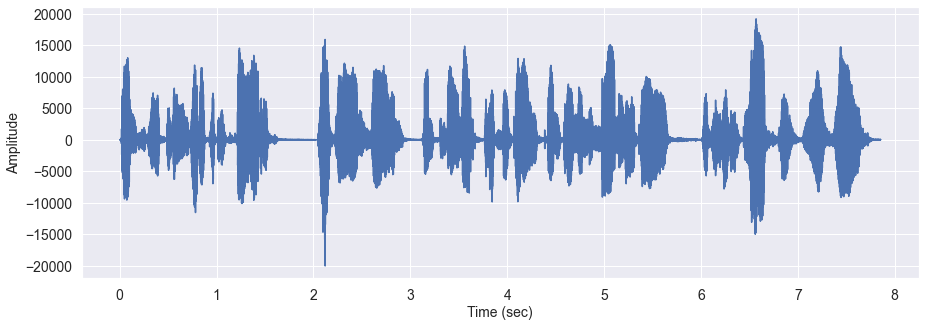

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Get the samples of the audio file.
samples = wav_file.get_array_of_samples()
time = np.arange(0, wav_file.duration_seconds,1/wav_file.frame_rate)

# Create the waveform with its data.
waveform_df = pd.DataFrame(columns=['time', 'samples'])

waveform_df['time'] = time
waveform_df['samples'] = samples

# Plot the waveform.
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=waveform_df, x=time, y=samples)

ax.set_xlabel('Time (sec)', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

We can also extract a few more interesting statistics for all waveforms, like their duration, maximum amplitude, and word count.

In [45]:
import re
# Store the audio statistics in a dataframe.
statistics_df = pd.DataFrame(columns=['duration_seconds', 'max', 'word_num', 'book_id'])
i = 1

for index, row in data_red.iterrows():
    i+=1
    wav_file = AudioSegment.from_file(file="./data/wav/" + row["audiofile"] + ".wav", format="wav")
    # Store the following as features.
    statistics_df = statistics_df.append({'duration_seconds':wav_file.duration_seconds, 
                                        'max':wav_file.max, 
                                        'word_num':len(row["transcription"].split()), 
                                        'book_id':row["book_id"]}, ignore_index=True)

statistics_df.head()

,duration_seconds,max,word_num,book_id
0,6.392608,18888,16,book1
1,5.788889,20927,19,book1
2,5.150340,29599,17,book1
3,3.455283,29092,10,book1
4,4.952971,22680,16,book1


The specific values can be presented in an elegant way using a pairplot.

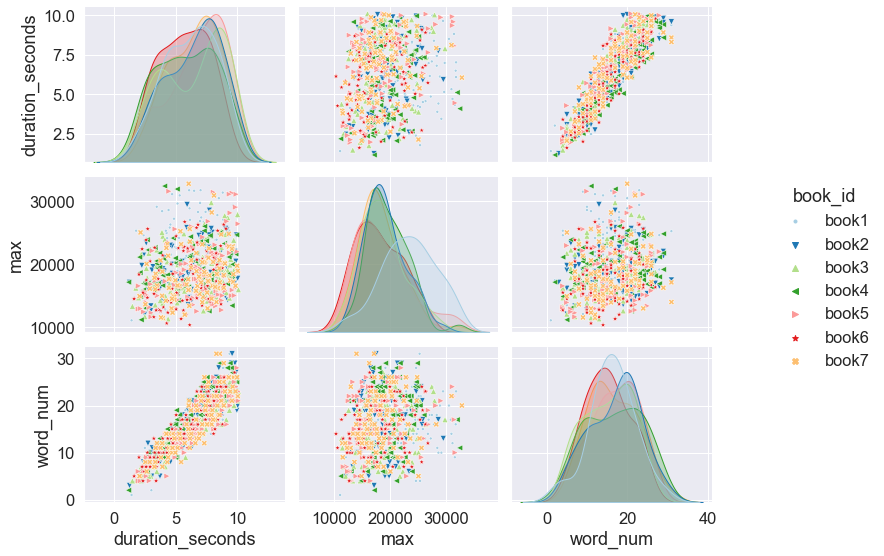

In [46]:
# Plot the statistics information.
sns.set(font_scale=1.5)
g = sns.pairplot(statistics_df, hue="book_id", palette="Paired", markers=[".", "v", "^", "<", ">", "*", "X"])
g.fig.set_size_inches(13,8)

## Using speech-to-text

``Speech-to-text``, also known as ``speech recognition``, allows for the real-time transcription of audio streams into text. 

First, we import the necessary module and setup the recognizer.

In [47]:
import speech_recognition as sr

# Create an instance of the recognizer.
recognizer = sr.Recognizer()
# Set the energy threshold.
recognizer.energy_threshold = 300

Iterating over all input files in the dataset, we transcribe the audio using the ``Google Speech Recognition API``, which is a cloud service to send audio and receive a text transcription.

In [48]:
import glob

# Check whether the file with the hypotheses exists.
file_exists = os.path.exists("./data/hypothesis.csv")

if not file_exists:
    
    # Store the result of the recognition.
    hypothesis = []
    i = 1

    # Start the speech-to-text process.
    for file in data_red["audiofile"]:
        print("Recognizing audio file: " + str(i) + " out of " + str(len(data_red["audiofile"])))
        i+=1
        # Read the audio file.
        audio_file = sr.AudioFile("./data/wav/" + file + ".wav")
        # Extract the file's audiodata.
        with audio_file as source:
            # Record the audio.
            file_audio_data = recognizer.record(source)
        try:
            # Transcribe speech using Goolge Speech REcognition API.
            hypothesis.append(recognizer.recognize_google(audio_data=file_audio_data, language="en-US"))
        except Exception as e:
            hypothesis.append("<ERROR>")
    
    # Save the hypotheses.
    hypothesis_df = pd.DataFrame(hypothesis, columns=['hypothesis'])
    hypothesis_df.to_csv("data/hypothesis.csv", line_terminator='\n', index=False)
else:
    # Retrieve the book ids.
    hypothesis_df = pd.read_csv('data/hypothesis.csv', names=['hypothesis'], skiprows=1)    

Next, we apply a few preprocessing steps in both ground truth transcriptions and the hypotheses.

In [49]:
# Preprocess the ground truth transcriptions and hypotheses.
ground_truth = data_red["transcription"].to_list()

# Remove the following symbols.
symbols = ",.!?;"
for i in range(len(ground_truth)):
    ground_truth[i] = ground_truth[i].lower()
    for c in symbols:
        ground_truth[i].replace(c, "")

hypothesis = hypothesis_df['hypothesis'].to_list()
for i in range(len(hypothesis)):
    hypothesis[i] = hypothesis[i].lower()

In [50]:
print(ground_truth[80])
print(hypothesis[80])

america has produced a good many showy books, the typography, paper, and illustrations of which are, however, all wrong,
america has produced a good many show ebooks the typography paper and illustrations of which are however


Let's measure the ``WER`` for our dataset.

In [51]:
from jiwer import wer

# Calculate the WER.
error = wer(ground_truth, hypothesis)
print(error)

0.22435540716008162


### K-means clustering

First, we load the speech-to-text hypotheses from the CSV file, filtering those samples with an error. Next, using tf-idf, we vectorize the input sentences.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

# Read the hypotheses from the speech-to-text.
hypothesis_df = pd.read_csv('data/hypothesis.csv', names=['hypothesis'])
hypothesis_df = hypothesis_df[hypothesis_df['hypothesis'] != "<ERROR>"]
data = hypothesis_df['hypothesis'] 

# Vectorize the hypotheses.
tf_idf_vectorizor = TfidfVectorizer(stop_words='english', max_features=5000)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

We can now apply the principal component analysis to reduce the dimensions of the feature space. Then we apply a handy technique called the ``elbow method`` to balance the tradeoff between coherent and meaningful clusters. 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Perform PCA to reduce the dimensions of the feature space with two principal components.
pca = PCA(n_components=2)
pcaComponents = pca.fit_transform(tf_idf_array)

# Use the elbow method to extract the optimal number of clusters.
num_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in num_clusters]

inertia = [kmeans[i].fit(pcaComponents).inertia_ for i in range(len(kmeans))]

plt.figure(figsize=(10, 5))
plt.plot(num_clusters, inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method')

We utilize the previous outcome to train a K-means model using 10000 iterations. 

In [ ]:
# Perform the clustering.
kmeans = KMeans(n_clusters=3, max_iter=10000, algorithm = 'full', n_init=200)
kmeans_model = kmeans.fit(pcaComponents)
kmeans_pred = kmeans.predict(pcaComponents)

# Plot the clusters.
plt.figure(figsize=(10, 5))
plt.scatter(pcaComponents[:, 0], pcaComponents[:, 1], c=kmeans_pred, s=50, cmap='Paired')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Plot the cluster centers.
centers = kmeans_model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=0.6)

Each sample is clustered in one of three groups.

The next method extracts the indices of the predictions in each cluster, calculates the mean tf-idf vector of the corresponding predictions, and returns the most relevant words.

In [ ]:
# Get top words (=num) per cluster.
def cluster_top_words(tf_idf_array, prediction, num):

    # Get the unique labels.
    labels = np.unique(prediction)
    top_words = []

    # Iterate over all labels.
    for label in labels:
        # Indices for each cluster.
        idx = np.where(prediction==label) 
        # Mean feature values across cluster.
        x_means = np.mean(tf_idf_array[idx], axis = 0)
        # Get the indices to sort x_means.
        sorted = np.argsort(x_means)[::-1][:num]
        # Get the list of words.
        words = tf_idf_vectorizor.get_feature_names()
        # Top words.
        top = [(words[i], x_means[i]) for i in sorted]
        df = pd.DataFrame(top, columns = ['features', 'score'])
        top_words.append(df)        
    
    return top_words

# Get the 15 top words per cluster.
top_words = cluster_top_words(tf_idf_array, kmeans_pred, 15)


We can now visualize the outcome of this step using the following code.

In [ ]:
# Plot the top words per cluster.
fig = plt.figure(figsize=(15, 6))
x = np.arange(len(top_words[0]))

for i, df in enumerate(top_words):
    ax = fig.add_subplot(1, len(top_words), i+1)
    ax.set_title("Cluster: " + str(i+1), fontsize=16)
    ax.set_frame_on(False)
    ax.set_xlabel('score')
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
    ax.set_yticks(np.arange(0, 15, 1))
    ax.barh(x, df.score, align='center', color='#0a7ff2')
    yticks = ax.set_yticklabels(df.features)

### DBSCAN clustering

In the following code, we use ``KNN`` to extract the distances between each point in the data set and its 5 nearest neighbors. Then we sort the distances in ascending values and create the plot to get the point of maximum curvature.

In [ ]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# Perform 5-nn to extract the distances. 
nn = NearestNeighbors(n_neighbors=5).fit(pcaComponents)
distances, idx = nn.kneighbors(pcaComponents)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Find the knee point.
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=0, curve='convex', direction='increasing', interp_method='polynomial')

# Plot the knee.
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.title('Knee point', fontsize=18)
plt.xlabel("Points", fontsize=16)
plt.ylabel("Distance", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['data', 'knee/elbow'], fontsize=16)

print("Knee point: " + str(distances[knee.knee]))

Based on the previous result let's apply the clustering method.

In [ ]:
from sklearn.cluster import DBSCAN

# Perform the clustering.
db = DBSCAN(eps=distances[knee.knee], min_samples=4, n_jobs=-1).fit(pcaComponents)
# Get the cluster labels.
labels = db.labels_
# Count the total number of clusters.
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
# Count the total number of noise points.
num_noise = list(labels).count(-1)

print('Number of clusters: %d' % num_clusters)
print('Number of noise points: %d' % num_noise)

Calculating the silhouette coefficient for our example and the distribution of the data points in each cluster follows.

In [ ]:
from sklearn import metrics

# Print the model results.
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pcaComponents, labels))

# Get the sample counts in each cluster
counts = np.bincount(labels[labels>=0])
print (counts)

Finally, let's plot the clusters as we did with the K-means case.

In [ ]:
# Plot the clusters.
colors = ['blue', 'yellow', 'green', 'red', 'black' #'red', 'deeppink', 'olive', 'goldenrod', #'lightcyan', 'navy'
]

vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.figure(figsize=(10, 5))
plt.scatter(pcaComponents[:,0], pcaComponents[:,1], c=vectorizer(labels))
plt.xlabel('PC1')
plt.ylabel('PC2')

## Hierarchical clustering

First, let's create the dendrogram for our dataset using agglomerative clustering and ``ward`` as the linkage function.

In [ ]:
from scipy.cluster import hierarchy

plt.figure(figsize=(12, 6))
dendro = hierarchy.dendrogram(hierarchy.linkage(pcaComponents, method='ward'))
plt.xlabel("hypothesis index", fontsize=16)
plt.ylabel("Euclidean distance", fontsize=16)
# Cut at 1.5 to get 3 clusters.
plt.axhline(y=1.5, color='black', linestyle='--')

In the following code snippet, we create an agglomerative clustering model and predict the cluster for each hypothesis.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Perform the clustering.
agg = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
agg_model = agg.fit_predict(pcaComponents)

Then, we proceed to the extraction of the 15 top words per cluster and provide the visualization of the results.

In [ ]:
# Get the 15 top words per cluster.
top_words = cluster_top_words(tf_idf_array, agg.labels_, 15)

# Plot the top words per cluster.
fig = plt.figure(figsize=(15, 6))
x = np.arange(len(top_words[0]))

for i, df in enumerate(top_words):
    ax = fig.add_subplot(1, len(top_words), i+1)
    ax.set_title("Cluster: " + str(i+1), fontsize=16)
    ax.set_frame_on(False)
    ax.set_xlabel('score')
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
    ax.set_yticks(np.arange(0, 15, 1))
    ax.barh(x, df.score, align='center', color='#0a7ff2')
    yticks = ax.set_yticklabels(df.features)

### Machine Learning Techniques for Text 
&copy;2021&ndash;2022, Nikos Tsourakis, <nikos@tsourakis.net>, Packt Publications. All Rights Reserved.